In [80]:
%reload_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

# import seaborn as sns

# sns.set_context("paper")
# sns.set_style("whitegrid")
# sns.despine()  

sys.path.append(os.path.join(os.getcwd(), os.pardir))
from plot import colorPanel, loader, stick
from plot.cd import cd
import glob
import json
#from plotting import cd
#from plotting import baseline_logger as bl

%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

In [81]:
def smooth_reward_curve(x, y):
    print (len(x))
    halfwidth = min(151, int(np.ceil(len(x)/15))) # Halfwidth of our smoothing convolution
    k = halfwidth
    xsmoo = x[k:-k]
    ysmoo = np.convolve(y, np.ones(2*k+1), mode='valid') / np.convolve(np.ones_like(y), np.ones(2*k+1), mode='valid')
    downsample = max(int(np.floor(len(xsmoo)/1e3)),1)
    return xsmoo[::downsample], ysmoo[::downsample]

def process_json(path):
    with open(path, 'r') as f:
        r = {'l': [], 'r': []}
        ccnt = 0
        kk = 0
        tmp = []
        ff = 1
        for line in f.readlines():
            if ff:
                ff = 0
                continue
            d = json.loads(line)
            kk += d['l']
            tmp.append(d['r'][0])
            if kk > 50:
                ccnt += 1
                r['l'].append(ccnt*50)
                kk = kk % 50
                r['r'].append(np.mean(tmp))
                tmp = []
    for k in ['l', 'r']:
        r[k] = np.array(r[k])
    return r


def average_dict(res, keys, er, rr):
    """
    :param res: the dict
    :param keys: keys
    :return: a dict with (key, (mean, std)) of results.
    """
    ret = dict()
    for k in keys:
        vs = [r[k] for r in res]
        l = min(v.shape[0] for v in vs)
        vs = [v[np.newaxis, :l] for v in vs]
        vs = np.concatenate(vs, axis=0)
        if k == 'r':
            vs = (vs-rr)/(er-rr)
        m, s = np.median(vs, axis=0), np.std(vs, axis=0, dtype=np.float64)
        ret[k] = [m, s]
    return ret

In [82]:
def get_data(prefix, criterion, er, rr):

    with cd(prefix):
        paths = glob.glob(criterion)
        d = dict()
        print (paths, criterion)
        for path in paths:
            files = glob.glob(path + '/seed-*/0.monitor.json')
            res = []
            for f in files:
                if not 'seed-10/' in f and not 'seed-12/' in f and not 'seed-14/' in f:
                    continue
                print (f)
                r = process_json(f)
                res.append(r)
            print (len(res))
            if True:
                res = average_dict(res, ['l', 'r'], er=er, rr=rr)
            d[path] = res
        #print (path)
        if len(paths) == 1:
            for k, v in d.items():
                return v
        else:
            return d

In [85]:
def plotArg(game, ax):
    env_id = game
    #env_id, traj_need = game.split('-')
    #traj_need = int(traj_need)
    colors = colorPanel.colorPanel(1).getColors()

    '''
    #print gail
    d_type = ['single', 'decentralized']#, 'centralized']
    plot_type = {'single': 'Cooperative', 'decentralized': 'Decentralized', 0: '', 500: '+BC'}
    bc_iter = [500]
    
    cnt = 0
    
    expert_reward = -13.5
    random_reward = -43
    
    for i in d_type:
        for j in bc_iter:
            datas = get_data(prefix='/atlas/u/hyren/exps', criterion='gail/%s/%s/s-%d/l-0.1-b-1000-d-0.1-c-%d/'%(env_id, i, traj_need, j),
                            er = expert_reward, rr = random_reward)
            label = '%s%s' % (plot_type[i], plot_type[j])

            
            x = datas['l']
            y = datas['r']

            x = x[0]
            y_mean = y[0]
            y_std = y[1]

            xx = x
            x, y_mean = smooth_reward_curve(xx, y_mean)
            x, y_std = smooth_reward_curve(xx, y_std)
            x = x * 1e7 / np.max(x)

            cnt += 1
            color = colors[cnt]

            y_upper = y_mean + y_std
            y_lower = y_mean - y_std
            ax.fill_between(
                x, list(y_lower), list(y_upper), interpolate=True, facecolor=color, linewidth=0.0, alpha=0.3
            )
            line = ax.plot(x, list(y_mean), label=label, color=color, rasterized=True)          
    '''
    if game == 'Cooperative Communication':
        d_type = ['Expert', 'Random', 'BC', 'Cooperative', 'Decentralized']
        draw_sym = ['-s', '-o', '-v', '-*', '-d']
        ex_num = [50, 100, 150, 200]
        re_m = np.array([[-6.2, -6.2, -6.2, -6.2], [-62.2, -62.2, -62.2, -62.2], [-21.2, -13.2, -11.3, -10.0], 
                [-15.65, -7.11, -7.11, -7.09], [-18.6, -8.058, -8.16, -7.34]])
        re_s = np.array([[4.5, 4.5, 4.5, 4.5], [28.7, 28.7, 28.7, 28.7], [10.6, 7.4, 5.9, 5.36], 
                [10.0, 4.81, 4.805, 4.806], [10.4, 5.3, 5.47, 4.86]])
        re_m_n = [np.array([1,1,1,1]), np.array([0,0,0,0])]
        re_s_n = []
        for i in range(2, len(d_type)):
            re_m_n.append((re_m[i]-re_m[1,0])/(re_m[0,0]-re_m[1,0]))
        for i in range(len(d_type)):
            re_s_n.append((re_s[i])/(re_m[0,0]-re_m[1,0])/9)
        x = [1,2,3,4]
        for i in range(len(d_type)):
            #if d_type[i] == 'Random':
            #    continue
            y_mean = re_m_n[i]
            y_upper = [y_mean[t]+re_s_n[i][t] for t in range(len(ex_num))]
            y_lower = [y_mean[t]-re_s_n[i][t] for t in range(len(ex_num))]
            ax.fill_between(
                 x, list(y_lower), list(y_upper), interpolate=True, facecolor=colors[i], linewidth=0.0, alpha=0.3
            )
            line = ax.plot(x, list(y_mean), '%s'%(draw_sym[i]), label=d_type[i], color=colors[i], rasterized=True)
            #line = ax.plot(x, list(y_mean), color=colors[i], '-s')
            print (x)
            print (y_mean)
            print (y_upper)
            print (y_lower)
        stick.cutsomStick(game, 'timesteps', ax)
        
#     if game == 'Cooperative Navigation':
#         d_type = ['Expert', 'Random', 'BC', 'Cooperative', 'Decentralized']
#         draw_sym = ['-s', '-o', '-h', '-*', '-d']
#         ex_num = [50, 100, 150, 200]
#         re_m = np.array([[-6.2, -6.2, -6.2, -6.2], [-62.2, -62.2, -62.2, -62.2], [-21.2, -13.2, -11.3, -10.0], 
#                 [-15.65, -7.11, -7.11, -7.09], [-18.6, -8.058, -8.16, -7.34]])
#         re_s = np.array([[4.5, 4.5, 4.5, 4.5], [28.7, 28.7, 28.7, 28.7], [10.6, 7.4, 5.9, 5.36], 
#                 [10.0, 4.81, 4.805, 4.806], [10.4, 5.3, 5.47, 4.86]])
#         re_m_n = [np.array([1,1,1,1]), np.array([0,0,0,0])]
#         re_s_n = []
#         for i in range(2, len(d_type)):
#             re_m_n.append((re_m[i]-re_m[1,0])/(re_m[0,0]-re_m[1,0]))
#         for i in range(len(d_type)):
#             re_s_n.append((re_s[i])/(re_m[0,0]-re_m[1,0])/9)
#         x = [1,2,3,4]
#         for i in range(len(d_type)):
#             #if d_type[i] == 'Random':
#             #    continue
#             y_mean = re_m_n[i]
#             y_upper = [y_mean[t]+re_s_n[i][t] for t in range(len(ex_num))]
#             y_lower = [y_mean[t]-re_s_n[i][t] for t in range(len(ex_num))]
#             ax.fill_between(
#                  x, list(y_lower), list(y_upper), interpolate=True, facecolor=colors[i], linewidth=0.0, alpha=0.3
#             )
#             line = ax.plot(x, list(y_mean), '%s'%(draw_sym[i]), label=d_type[i], color=colors[i], rasterized=True)
#             #line = ax.plot(x, list(y_mean), color=colors[i], '-s')
#             print (x)
#             print (y_mean)
#             print (y_upper)
#             print (y_lower)
#         stick.cutsomStick(game, 'timesteps', ax)
        
    ax.set_ylim(-0.1,1.1)
    ax.set_xlim(0.8,4.2)
    ax.set_xticklabels(['100','200','300','400'])
    set(ax,'ydir','reverse','yscale','log')

[1, 2, 3, 4]
[1 1 1 1]
[1.0089285714285714, 1.0089285714285714, 1.0089285714285714, 1.0089285714285714]
[0.9910714285714286, 0.9910714285714286, 0.9910714285714286, 0.9910714285714286]
[1, 2, 3, 4]
[0 0 0 0]
[0.056944444444444436, 0.056944444444444436, 0.056944444444444436, 0.056944444444444436]
[-0.056944444444444436, -0.056944444444444436, -0.056944444444444436, -0.056944444444444436]
[1, 2, 3, 4]
[ 0.73214286  0.875       0.90892857  0.93214286]
[0.75317460317460316, 0.88968253968253963, 0.92063492063492069, 0.94277777777777783]
[0.71111111111111103, 0.86031746031746037, 0.89722222222222237, 0.9215079365079365]
[1, 2, 3, 4]
[ 0.83125     0.98375     0.98375     0.98410714]
[0.85109126984126993, 0.99329365079365084, 0.99328373015873017, 0.99364285714285716]
[0.81140873015873016, 0.97420634920634919, 0.97421626984126986, 0.97457142857142853]
[1, 2, 3, 4]
[ 0.77857143  0.96682143  0.965       0.97964286]
[0.79920634920634925, 0.97733730158730159, 0.97585317460317467, 0.9892857142857143

TypeError: set expected at most 1 arguments, got 5

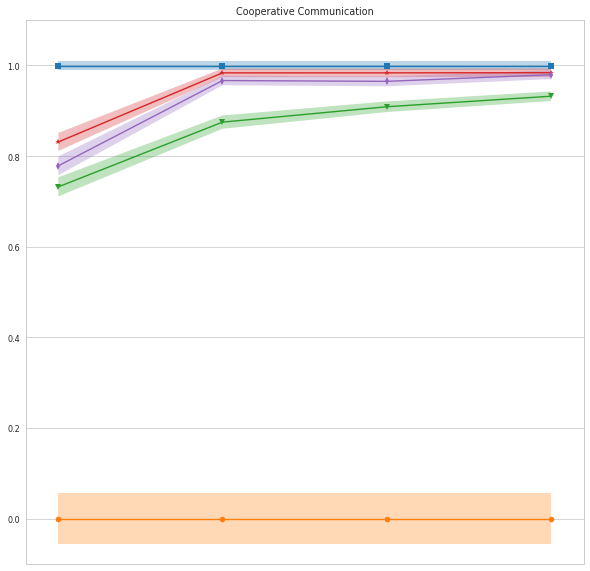

In [86]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
columns = 1
sixAtariGames = [
    'Cooperative Communication', 
    #'Cooperative Navigation'
]

# ax.spines['top'].set_color('none')
# ax.spines['bottom'].set_color('none')
# ax.spines['left'].set_color('none')
# ax.spines['right'].set_color('none')
# ax.tick_params(labelcolor='b', top='off', bottom='off', left='off', right='off')


for i, args in enumerate(sixAtariGames):
    #print(args)
    #ax = fig.add_subplot(len(sixAtariGames) / columns + 1, columns, i + 1)
    plotArg(args, ax)

#plt.legend(loc=4)

lgd = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.5),
          fancybox=True, shadow=True, ncol=5)

# ax.set_xlabel('Number of Timesteps')
# ax.set_ylabel('Episode Rewards')

fig.tight_layout()
fig.savefig('cooperative_result.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')